In [121]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
import re
import numpy as np

In [122]:
text = """
Vinicius de Moraes e Toquinho
Aquarela

Numa folha qualquer
Eu desenho um sol amarelo
E com cinco ou seis retas
É fácil fazer um castelo

Corro o lápis em torno
Da mão e me dou uma luva
E se faço chover
Com dois riscos tenho um guarda-chuva

Se um pinguinho de tinta
Cai num pedacinho
Azul do papel
Num instante imagino
Uma linda gaivota
A voar no céu

Vai voando, contornando
A imensa curva norte-sul
Vou com ela viajando
Havaí, Pequim ou Istambul

Pinto um barco a vela
Brando navegando
É tanto céu e mar num beijo azul

Entre as nuvens vem surgindo
Um lindo avião rosa e grená
Tudo em volta colorindo
Com suas luzes a piscar

Basta imaginar e ele está partindo
Sereno, lindo, leve
E aí desperta e cai
Numa nova manhã, criando
Novos sonhos de fazer navegar

Todo mundo ama um dia
Todo mundo chora
Um dia a gente chega
E no outro vai embora

Cada um de nós compõe a sua história
E ser feliz é tão fácil
Quando se tem o coração

Na direção
Cert

Aquarela, aquarela
Numa folha qualquer eu desenho um sol amarelo (uhu)
Que descolorirá meu quintal (uhu)
Com cinco ou seis retas é fácil fazer um castelo (uhu)
Corro o lápis em torno da mão e me dou uma luva (uhu)
E se faço chover, com dois riscos tenho um guarda-chuva (uhu)
Se um pinguinho de tinta cai num pedacinho azul do papel (uhu)
Num instante imagino uma linda gaivota a voar no céu (uhu)

Vai voando, contornando a imensa curva norte-sul (uhu)
Vou com ela viajando, Havaí, Pequim ou Istambul (uhu)
Pinto um barco a vela, brando navegando (uhu)
É tanto céu e mar num beijo azul (uhu)

Entre as nuvens vem surgindo um lindo avião rosa e grená (uhu)
Tudo em volta colorindo, com suas luzes a piscar (uhu)
Basta imaginar e ele está partindo, sereno, lindo, leve (uhu)
E então, desenho um grande navio
Bem bonito navegando
É tanto céu e mar num beijo azul

Aquarela, aquarela
É assim que se faz um quadro
De uma linda paisagem
Num pedaço de papel
"""

text = re.sub(r'[^\w\s]', '', text)
text = text.lower()
text = text.replace('\n', ' ')
stopwords = ['de', 'com', 'para', 'bem', 'que'] # Define uma lista de stopwords
text = ' '.join([palavra for palavra in text.split() if palavra not in stopwords]) # Remove as stopwords

In [123]:
# criando o objeto Tokenizer
tokenizer = Tokenizer()

# ajustando o Tokenizer ao texto
tokenizer.fit_on_texts([text])

# convertendo o texto em sequências numéricas
sequences = tokenizer.texts_to_sequences([text])[0]

# retorna o índice de palavras criado pelo Tokenizer
word_index = tokenizer.word_index

# tamanho do vocabulário
vocab_size = len(tokenizer.word_index) + 1

In [124]:
# definindo o tamanho da janela
window_size = 3

# criando sequências de palavras de tamanho fixo
sequences = np.array(sequences)
X = []
y = []
for i in range(window_size, len(sequences)):
    X.append(sequences[i-window_size:i])
    y.append(sequences[i])
X = np.array(X)
y = np.array(y)

# codificando a saída como one-hot vectors
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

In [125]:
# Define o modelo LSTM para geração de texto
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=20, input_length=window_size),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=vocab_size, activation='softmax')
])

In [126]:
early_stop = EarlyStopping(monitor='loss', patience=20)

In [127]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)


In [128]:
# Compila o modelo]
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [129]:
# treinando o modelo
history = model.fit(X, y, epochs=500, callbacks=[early_stop], verbose=1)

Epoch 1/500
11/11 [==============================] - 4s 15ms/step - loss: 4.9548 - accuracy: 0.0240
Epoch 2/500
11/11 [==============================] - 0s 14ms/step - loss: 4.9443 - accuracy: 0.0599
Epoch 3/500
11/11 [==============================] - 0s 13ms/step - loss: 4.9238 - accuracy: 0.0569
Epoch 4/500
11/11 [==============================] - 0s 12ms/step - loss: 4.8598 - accuracy: 0.0539
Epoch 5/500
11/11 [==============================] - 0s 13ms/step - loss: 4.7077 - accuracy: 0.0539
Epoch 6/500
11/11 [==============================] - 0s 12ms/step - loss: 4.6464 - accuracy: 0.0389
Epoch 7/500
11/11 [==============================] - 0s 11ms/step - loss: 4.5749 - accuracy: 0.0599
Epoch 8/500
11/11 [==============================] - 0s 11ms/step - loss: 4.5117 - accuracy: 0.0479
Epoch 9/500
11/11 [==============================] - 0s 11ms/step - loss: 4.4143 - accuracy: 0.0479
Epoch 10/500
11/11 [==============================] - 0s 11ms/step - loss: 4.3548 - accuracy: 0.0509

In [130]:
def generate_text(model, tokenizer, seed_text, next_words):
    for _ in range(next_words):
        # Tokenização do seed_text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=window_size, padding='pre')
        
        # Previsão do próximo token
        predicted = model.predict(token_list)[0]
        predicted_word_index = np.argmax(predicted)
        
        # Encontrar a palavra correspondente ao índice
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        
        # Adicionar a palavra ao texto gerado
        seed_text += " " + output_word

        # # Atualizar a sequência de entrada
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=next_words-1, padding='pre')
        
    return seed_text


In [131]:
generated_text = generate_text(model, tokenizer, 'Numa folha qualquer', 20)
print(generated_text)

1/1 [==============================] - 0s 25ms/step
Numa folha qualquer eu desenho um sol amarelo e cinco ou seis retas é fácil fazer um castelo corro o lápis em torno


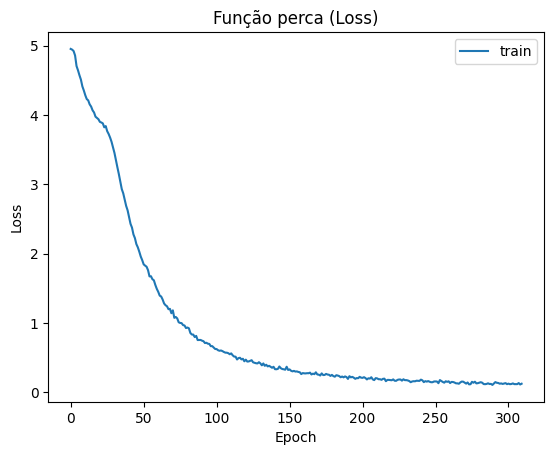

In [132]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.title('Função perca (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [134]:
test_loss, test_acc = model.evaluate(X, y)

11/11 [==============================] - 1s 6ms/step - loss: 0.0863 - accuracy: 0.9581
